In [1]:
from fdm_tools import *
from my_packages import *

In [2]:
# -----------------------------
# Program Parameters
# -----------------------------

# Grid and domain parameters
# nx, ny = 40, 100
x0, xL = 0.0, 10
y0, yL = 0.0, 20

# Boundary values
Tleft, Tright, Ttop, Tbot = 0.0, 0.0, 10, 50.0

# Discretization parameters
# dx = (xL - x0) / (nx - 1)
# dy = (yL - y0) / (ny - 1)

dx = 0.1
dy = 0.2

nx = int((xL-x0)/dx)+1
ny = int((yL-y0)/dx)+1

print(nx, ny)
# Coefficients
DX1, DY1 = 1.0, 1.0
A1 = DX1 / pow(dx, 2)
A2 = DY1 / pow(dy, 2)
A3 = -2.0 * DX1 / pow(dx, 2) - 2.0 * DY1 / pow(dy, 2)
A4 = DY1 / pow(dy, 2)
A5 = DX1 / pow(dx, 2)

# Boundary conditions
ibound_array = np.ones((nx, ny))

ibound_array[:int(3*nx/5), :int(7*ny/10)] = 0
ibound_array[int(3*nx/5):, 0] = -1
ibound_array[0, int(7*ny/10):] = -2
ibound_array[-1, :] = 0
ibound_array[:, -1] = 0

constant_head = {-1: Ttop, -2: Tbot}

101 201


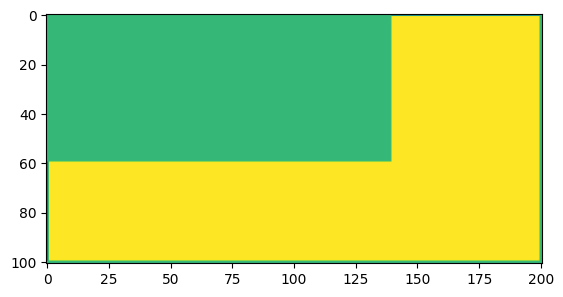

In [3]:
plt.imshow(ibound_array, origin="upper")
# plt.xticks(ticks=np.arange(ibound_array.shape[1]), labels=np.arange(ibound_array.shape[1]))
# plt.yticks(ticks=np.arange(ibound_array.shape[0]), labels=np.arange(ibound_array.shape[0]))
plt.show()

In [4]:
# -----------------------------
# Initialize Matrices
# -----------------------------

AA = np.zeros((nx * ny, nx * ny))
BB = np.zeros(nx * ny)

no = lambda i, j: j * nx + i  # Function to map 2D indices to linear index

In [5]:
# -----------------------------
# Categorize Nodes
# -----------------------------

nodes_by_type = categorize_nodes(ibound_array, nx, ny)

In [6]:
exclude_nodes = []
# No-flow boundaries
for i, j in nodes_by_type["0"]:
    valid_neighbor = locate_valid_neighbors(ibound_array, i, j, nx, ny)
    nn = no(i, j)
    if valid_neighbor:
        ii, jj = valid_neighbor
        mm = no(ii, jj)
        AA[nn][nn] = 1 / dx
        AA[nn][mm] = -1 / dx
        BB[nn] = 0
    else:
        exclude_nodes.append(nn)

# Constant head boundaries
for i, j in nodes_by_type["negative"]:
    nn = no(i, j)
    boundary_value = ibound_array[i, j]
    AA[nn][nn] = 1
    BB[nn] = constant_head[boundary_value]

# Active cells
for i, j in nodes_by_type["positive"]:
    nn = no(i, j)
    nl = no(i, j - 1)  # left
    nr = no(i, j + 1)  # right
    nu = no(i - 1, j)  # up
    nd = no(i + 1, j)  # down
    AA[nn][nl] = A1
    AA[nn][nd] = A2
    AA[nn][nn] = A3
    AA[nn][nu] = A4
    AA[nn][nr] = A5
    BB[nn] = 0

In [7]:
def drop_node(A, B, exclude_nodes):
    # Create a boolean mask to indicate which rows and columns to keep
    mask = np.ones(A.shape[0], dtype=bool)
    mask[exclude_nodes] = False

    # Apply the mask to remove the excluded rows and columns from A
    A_reduced = A[mask, :][:, mask]

    # Apply the mask to remove the corresponding elements from B
    B_reduced = B[mask]

    return A_reduced, B_reduced

refine_AA, refine_BB = drop_node(AA, BB, exclude_nodes)

In [8]:
CC = solve(np.array(refine_AA, dtype=np.float32), np.array(refine_BB, dtype=np.float32))

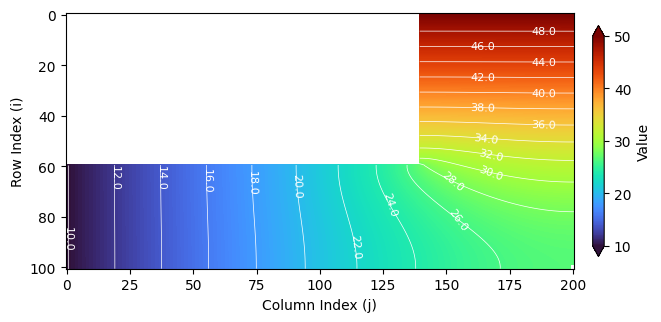

In [9]:
def visualize_with_exclusions(CC, excluded_nodes, nx, ny, fill_value=np.nan):
    """
    Visualizes the solution from the solver while accounting for excluded nodes.

    Parameters:
    - CC: 1D numpy array of the solution for included nodes.
    - excluded_nodes: List of node indices that were excluded.
    - nx, ny: Dimensions of the original grid.
    - fill_value: Value to fill for excluded nodes (default: NaN).

    Returns:
    - grid: 2D numpy array of the solution mapped to the original grid.
    """
    total_nodes = nx * ny
    included_nodes = [node for node in range(total_nodes) if node not in excluded_nodes]
    
    # Initialize the grid with the fill value
    grid = np.full((nx, ny), fill_value)
    
    # Map the solution back to the original grid
    for idx, node in enumerate(included_nodes):
        i = node % nx  # Row index
        j = node // nx  # Column index
        grid[i, j] = CC[idx]
    
    return grid

def plot_grid(grid, contour_interval=1.0):
    """
    Plots the reconstructed 2D grid using a heatmap.

    Parameters:
    - grid: 2D numpy array of the solution.
    - title: Title for the plot.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot heatmap
    im = plt.imshow(grid, cmap="turbo", origin="upper", interpolation="bilinear")
    plt.colorbar(im, label="Value", shrink=0.5, extend='both', pad=0.03)
    
    # Add contour lines
    levels = np.arange(np.nanmin(grid), np.nanmax(grid) + contour_interval, contour_interval)
    contours = plt.contour(grid, levels=levels, colors='white', linewidths=0.5, origin='lower')
    plt.clabel(contours, inline=False, fontsize=8, fmt="%.1f")  # Add labels to contours

    # Add plot details
    # plt.title(title)
    plt.xlabel("Column Index (j)")
    plt.ylabel("Row Index (i)")
    # plt.xticks(ticks=np.arange(grid.shape[1]), labels=np.arange(grid.shape[1]))
    # plt.yticks(ticks=np.arange(grid.shape[0]), labels=np.arange(grid.shape[0]))
    plt.show()

# Reconstruct the full grid
grid = visualize_with_exclusions(CC, exclude_nodes, nx, ny)

# Plot the grid
plot_grid(grid, contour_interval=2)